#### IMPORTING libraries

In [1]:
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml import feature
from pyspark.ml import clustering
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from math import exp, log10, fabs, atan, log
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

### To Read csv

In [2]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

#### Reading the cleaned data

In [3]:
hosp_readmit_df = spark.read.csv('hospital_readmission_cleaned.csv', header=True, inferSchema=True)

#### Printing the head and shape of the dataframe

In [4]:
print("Shape of hosp_readmit_df is: ",(hosp_readmit_df.count(), len(hosp_readmit_df.columns)))
hosp_readmit_df.toPandas().head()

Shape of hosp_readmit_df is:  (101766, 35)


,race,diag_1,diag_2,diag_3,admission_type_name,dischage_disposition_name,admission_source_name,gender,age,time_in_hospital,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,Caucasian,250.83,276,276,Emergency,Not Mapped,Physician Referral,Female,[0-10),1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,276,250.01,255,Emergency,Discharged to home,Emergency Room,Female,[10-20),3,...,No,No,No,No,No,Up,No,Ch,Yes,1
2,AfricanAmerican,648,250,V27,Emergency,Discharged to home,Emergency Room,Female,[20-30),2,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,8,250.43,403,Emergency,Discharged to home,Emergency Room,Male,[30-40),2,...,No,No,No,No,No,Up,No,Ch,Yes,0
4,Caucasian,197,157,250,Emergency,Discharged to home,Emergency Room,Male,[40-50),1,...,No,No,No,No,No,Steady,No,Ch,Yes,0


## A. Principal Component Analysis

### 1. Removing Target Variable for PCA

In [5]:
columns_to_drop = ['readmitted']
hosp_readmit_df1 = hosp_readmit_df.select([c for c in hosp_readmit_df.columns if c not in columns_to_drop])

### 2. Performing One Hot Encoding to convert all categorical variable to dummies prior to PCA, since PCA requires all the variables to be numerical
##### The pipeline consists of an indexer which assigns indexes in the form of numbers to all the distinct categories of a column. The indexer is followed by an encoder which creates a one hot encoded vector which we will look at below

In [6]:
categorical_columns= ['race','diag_1','diag_2','diag_3','admission_type_name','dischage_disposition_name','admission_source_name',
               'gender','age','max_glu_serum','A1Cresult','metformin','repaglinide',
               'nateglinide','chlorpropamide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','acarbose',
               'miglitol','insulin','glyburide-metformin','change','diabetesMed']
# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]
pipeline = Pipeline(stages=indexers+encoders)
model=pipeline.fit(hosp_readmit_df1)
hosp_readmit_df2 = model.transform(hosp_readmit_df1)

#### Obtaining a list of all the encoded columns after performing one hot Encoding so as to identify the most important columns based on the absolute values of the coefficients of PC1 & PC2 loading vectors

In [7]:
raceIdx = hosp_readmit_df2.select("race","race_indexed").distinct().rdd.collectAsMap()
raceIdx =  sorted((value, "race_" + key) for (key, value) in raceIdx.items())

diag_1Idx = hosp_readmit_df2.select("diag_1","diag_1_indexed").distinct().rdd.collectAsMap()
diag_1Idx =  sorted((value, "diag_1_" + key) for (key, value) in diag_1Idx.items())

diag_2Idx = hosp_readmit_df2.select("diag_2","diag_2_indexed").distinct().rdd.collectAsMap()
diag_2Idx =  sorted((value, "diag_2_" + key) for (key, value) in diag_2Idx.items())

diag_3Idx = hosp_readmit_df2.select("diag_3","diag_3_indexed").distinct().rdd.collectAsMap()
diag_3Idx =  sorted((value, "diag_3_" + key) for (key, value) in diag_3Idx.items())

admission_type_nameIdx = hosp_readmit_df2.select("admission_type_name","admission_type_name_indexed").distinct().rdd.collectAsMap()
admission_type_nameIdx =  sorted((value, "admission_type_name_" + key) for (key, value) in admission_type_nameIdx.items())

dischage_disposition_nameIdx = hosp_readmit_df2.select("dischage_disposition_name","dischage_disposition_name_indexed").distinct().rdd.collectAsMap()
dischage_disposition_nameIdx =  sorted((value, "dischage_disposition_name" + key) for (key, value) in dischage_disposition_nameIdx.items())

admission_source_nameIdx = hosp_readmit_df2.select("admission_source_name","admission_source_name_indexed").distinct().rdd.collectAsMap()
admission_source_nameIdx =  sorted((value, "admission_source_name" + key) for (key, value) in admission_source_nameIdx.items())

genderIdx = hosp_readmit_df2.select("gender","gender_indexed").distinct().rdd.collectAsMap()
genderIdx =  sorted((value, "gender" + key) for (key, value) in genderIdx.items())

ageIdx = hosp_readmit_df2.select("age","age_indexed").distinct().rdd.collectAsMap()
ageIdx =  sorted((value, "age" + key) for (key, value) in ageIdx.items())

ageIdx = hosp_readmit_df2.select("age","age_indexed").distinct().rdd.collectAsMap()
ageIdx =  sorted((value, "age" + key) for (key, value) in ageIdx.items())

max_glu_serumIdx = hosp_readmit_df2.select("max_glu_serum","max_glu_serum_indexed").distinct().rdd.collectAsMap()
max_glu_serumIdx =  sorted((value, "max_glu_serum" + key) for (key, value) in max_glu_serumIdx.items())

A1CresultIdx = hosp_readmit_df2.select("A1Cresult","A1Cresult_indexed").distinct().rdd.collectAsMap()
A1CresultIdx =  sorted((value, "A1Cresult" + key) for (key, value) in A1CresultIdx.items())

metforminIdx = hosp_readmit_df2.select("metformin","metformin_indexed").distinct().rdd.collectAsMap()
metforminIdx =  sorted((value, "metformin" + key) for (key, value) in metforminIdx.items())

repaglinideIdx = hosp_readmit_df2.select("repaglinide","repaglinide_indexed").distinct().rdd.collectAsMap()
repaglinideIdx =  sorted((value, "repaglinide" + key) for (key, value) in repaglinideIdx.items())

nateglinideIdx = hosp_readmit_df2.select("nateglinide","nateglinide_indexed").distinct().rdd.collectAsMap()
nateglinideIdx =  sorted((value, "nateglinide" + key) for (key, value) in nateglinideIdx.items())

chlorpropamideIdx = hosp_readmit_df2.select("chlorpropamide","chlorpropamide_indexed").distinct().rdd.collectAsMap()
chlorpropamideIdx =  sorted((value, "chlorpropamide" + key) for (key, value) in chlorpropamideIdx.items())

glimepirideIdx = hosp_readmit_df2.select("glimepiride","glimepiride_indexed").distinct().rdd.collectAsMap()
glimepirideIdx =  sorted((value, "glimepiride" + key) for (key, value) in glimepirideIdx.items())

glipizideIdx = hosp_readmit_df2.select("glipizide","glipizide_indexed").distinct().rdd.collectAsMap()
glipizideIdx =  sorted((value, "glipizide" + key) for (key, value) in glipizideIdx.items())

glyburideIdx = hosp_readmit_df2.select("glyburide","glyburide_indexed").distinct().rdd.collectAsMap()
glyburideIdx =  sorted((value, "glyburide" + key) for (key, value) in glyburideIdx.items())

pioglitazoneIdx = hosp_readmit_df2.select("pioglitazone","pioglitazone_indexed").distinct().rdd.collectAsMap()
pioglitazoneIdx =  sorted((value, "pioglitazone" + key) for (key, value) in pioglitazoneIdx.items())

rosiglitazoneIdx = hosp_readmit_df2.select("rosiglitazone","rosiglitazone_indexed").distinct().rdd.collectAsMap()
rosiglitazoneIdx =  sorted((value, "rosiglitazone" + key) for (key, value) in rosiglitazoneIdx.items())

acarboseIdx = hosp_readmit_df2.select("acarbose","acarbose_indexed").distinct().rdd.collectAsMap()
acarboseIdx =  sorted((value, "acarbose" + key) for (key, value) in acarboseIdx.items())

miglitolIdx = hosp_readmit_df2.select("miglitol","miglitol_indexed").distinct().rdd.collectAsMap()
miglitolIdx =  sorted((value, "miglitol" + key) for (key, value) in miglitolIdx.items())

insulinIdx = hosp_readmit_df2.select("insulin","insulin_indexed").distinct().rdd.collectAsMap()
insulinIdx =  sorted((value, "insulin" + key) for (key, value) in insulinIdx.items())

glyburidemetforminIdx = hosp_readmit_df2.select("glyburide-metformin","glyburide-metformin_indexed").distinct().rdd.collectAsMap()
glyburidemetforminIdx =  sorted((value, "glyburide-metformin" + key) for (key, value) in glyburidemetforminIdx.items())

changeIdx = hosp_readmit_df2.select("change","change_indexed").distinct().rdd.collectAsMap()
changeIdx =  sorted((value, "change" + key) for (key, value) in changeIdx.items())

diabetesMedIdx = hosp_readmit_df2.select("diabetesMed","diabetesMed_indexed").distinct().rdd.collectAsMap()
diabetesMedIdx =  sorted((value, "diabetesMed" + key) for (key, value) in diabetesMedIdx.items())

#newCols = list(map(lambda x: x[1], raceIdx))

#### Storing all the one hot encoded column names and numeric column names in a list

In [8]:
cols = [raceIdx,diag_1Idx,diag_2Idx,diag_3Idx,admission_type_nameIdx,dischage_disposition_nameIdx,admission_source_nameIdx
,genderIdx,ageIdx,max_glu_serumIdx,A1CresultIdx,metforminIdx,repaglinideIdx,nateglinideIdx,chlorpropamideIdx,glimepirideIdx
,glipizideIdx,glyburideIdx,pioglitazoneIdx,rosiglitazoneIdx,acarboseIdx,miglitolIdx,insulinIdx,glyburidemetforminIdx
,changeIdx,diabetesMedIdx]
newCols = []
for i in cols:
    newCols = newCols+list(map(lambda x: x[1], i))
newCols = newCols + ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
                     'number_emergency','number_inpatient','number_diagnoses']

In [9]:
#### Length of the list should equal the number of one hot encoded features/columns
len(newCols)

2390

#### Examining the One Hot Encoded Output by looking at a few columns
##### The Encoder creates a vector with 3 components, the first component denotes the number of distinct categories in the column and the second component denotes the index of the vector in which the number '1' is found and the third component [1.0] denotes the number which is found in the index mentioned by the second component. 
##### For example (4, [3], [1.0] ) means that, the vector is of length 4 (4 columns) since there are 4 distinct categories and the number '1.0' is present only in the 3rd index of the vector and rest of the indices contain number '0.0'

In [10]:
hosp_readmit_df2.select('time_in_hospital','insulin_indexed_encoded',
                        'change_indexed_encoded','diabetesMed_indexed_encoded').show(5)

+----------------+-----------------------+----------------------+---------------------------+
|time_in_hospital|insulin_indexed_encoded|change_indexed_encoded|diabetesMed_indexed_encoded|
+----------------+-----------------------+----------------------+---------------------------+
|               1|          (4,[0],[1.0])|         (2,[0],[1.0])|              (2,[1],[1.0])|
|               3|          (4,[3],[1.0])|         (2,[1],[1.0])|              (2,[0],[1.0])|
|               2|          (4,[0],[1.0])|         (2,[0],[1.0])|              (2,[0],[1.0])|
|               2|          (4,[3],[1.0])|         (2,[1],[1.0])|              (2,[0],[1.0])|
|               1|          (4,[1],[1.0])|         (2,[1],[1.0])|              (2,[0],[1.0])|
+----------------+-----------------------+----------------------+---------------------------+
only showing top 5 rows



#### Only picking the one hot encoded columns & numeric columns before doing PCA

In [11]:
required_cols =['race_indexed_encoded','diag_1_indexed_encoded','diag_2_indexed_encoded','diag_3_indexed_encoded','admission_type_name_indexed_encoded',
'dischage_disposition_name_indexed_encoded','admission_source_name_indexed_encoded','gender_indexed_encoded','age_indexed_encoded',
'max_glu_serum_indexed_encoded','A1Cresult_indexed_encoded','metformin_indexed_encoded','repaglinide_indexed_encoded',
'nateglinide_indexed_encoded','chlorpropamide_indexed_encoded','glimepiride_indexed_encoded','glipizide_indexed_encoded',
'glyburide_indexed_encoded','pioglitazone_indexed_encoded','rosiglitazone_indexed_encoded','acarbose_indexed_encoded',
'miglitol_indexed_encoded','insulin_indexed_encoded','glyburide-metformin_indexed_encoded','change_indexed_encoded',
'diabetesMed_indexed_encoded','time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
'number_emergency','number_inpatient','number_diagnoses']

hosp_readmit_df3 = hosp_readmit_df2.select([c for c in required_cols])

### 3. Using Vector Assembler, Standard Scaler and PCA to generate the Principal Components

##### Standard Scaler is to ensure that the all the features are centered with mean 0, as PCA requires all the features to have mean 0, and since the variables in this data have different units and different scales, we will also be setting the standard deviation as 1, so that one variable does not dominate over the other

##### We are building 2 principal components as, the first 2 PCs are the most important ones which explain majority of the variation in the data, and the features with the highest absolute value of loading vector coefficients in the first two PCs will be the most important variables

In [12]:
assembler = VectorAssembler(inputCols=[c for c in hosp_readmit_df3.columns],outputCol="features_va")
standard_scaler = feature.StandardScaler(withMean=True,withStd = True,inputCol='features_va', outputCol='zfeatures')
PCA = feature.PCA(k=2, inputCol='zfeatures', outputCol='pca_scores')

pipe_pca = Pipeline(stages=[assembler,standard_scaler,PCA]).fit(hosp_readmit_df3)
hosp_readmit_pca_df = pipe_pca.transform(hosp_readmit_df3).select('pca_scores')

### 4. Printing the top 10 features for both PC1 & PC2 to identify the most important features which explain a large amount of variation in the data

#### Features selected on the basis of the absolute values of the loading vector of PC1 & PC2

In [13]:
loadings = pipe_pca.stages[-1].pc.toArray()
first_component_loading = abs(loadings[:,0])
second_component_loading = abs(loadings[:,1])

first_component_loading = abs(first_component_loading)
second_component_loading = abs(second_component_loading)

pc1_dict = {'feature':newCols,'abs_loading':first_component_loading}
pc1_pd = pd.DataFrame(pc1_dict)
pc1_pd = pc1_pd.sort_values('abs_loading',ascending = False).head(10)

pc2_dict = {'feature':newCols,'abs_loading':second_component_loading}
pc2_pd = pd.DataFrame(pc2_dict)
pc2_pd = pc2_pd.sort_values('abs_loading',ascending = False).head(10)

print(pc1_pd)
print(pc2_pd)

              feature  abs_loading
2378         changeNo     0.383429
2379         changeCh     0.383429
2381    diabetesMedNo     0.361159
2380   diabetesMedYes     0.361159
2370        insulinNo     0.277394
2326      metforminNo     0.188435
2385  num_medications     0.182882
2327  metforminSteady     0.171727
2373        insulinUp     0.144420
2372      insulinDown     0.141952
                                       feature  abs_loading
2258             admission_type_name_Emergency     0.368400
2289      admission_source_name Emergency Room     0.367960
2290  admission_source_name Physician Referral     0.360340
2259              admission_type_name_Elective     0.322756
2383                        num_lab_procedures     0.218369
2384                            num_procedures     0.155462
2389                          number_diagnoses     0.139227
6                                   diag_1_414     0.124082
12                                  diag_1_715     0.121701
2260           

### 5. SCREE PLOT & CUMMULATIVE VARIANCE PLOT to identify number of principal components that explain what % of the variation in the data

In [14]:
assembler = VectorAssembler(inputCols=[c for c in hosp_readmit_df3.columns],outputCol="features_va")
standard_scaler = feature.StandardScaler(withMean=True,withStd = True,inputCol='features_va', outputCol='zfeatures')
PCA = feature.PCA(k=2390, inputCol='zfeatures', outputCol='pca_scores')
pipe_pca2 = Pipeline(stages=[assembler,standard_scaler,PCA]).fit(hosp_readmit_df3)

explainedVariance = pipe_pca2.stages[-1].explainedVariance



#### From the Scree plot we can observe that 1st component explains 0.2% of the variation in the data and from the cummulative plot we can observe that 2000 components explain around 80% of the variation in the data

#### Hence PCA can't be used for dimensionality reduction & feature selection, in this dataset as a large number of components (2000+) are required to explain a siginificant amount of variation ( ~80%) in the data

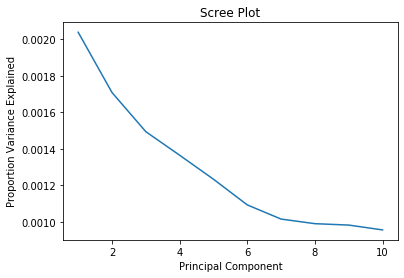

In [15]:
plt.plot(np.arange(1, 11), explainedVariance[0:10])
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")
display()

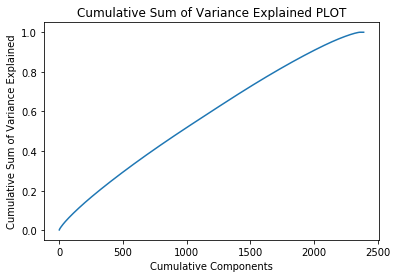

In [16]:
cum_sum = np.cumsum(explainedVariance)
plt.plot(np.arange(1, len(explainedVariance)+1), cum_sum)
plt.title("Cumulative Sum of Variance Explained PLOT")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")
display()

## B. Gradient Boosting Machine

### 1. Performing One Hot Encoding again by including the target variable in the dataset

In [4]:
categorical_columns= ['race','diag_1','diag_2','diag_3','admission_type_name','dischage_disposition_name','admission_source_name',
               'gender','age','max_glu_serum','A1Cresult','metformin','repaglinide',
               'nateglinide','chlorpropamide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','acarbose',
               'miglitol','insulin','glyburide-metformin','change','diabetesMed']
# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]
pipeline = Pipeline(stages=indexers+encoders)
model=pipeline.fit(hosp_readmit_df)
hosp_readmit_df_gb = model.transform(hosp_readmit_df)

In [5]:
hosp_readmit_df_gb = hosp_readmit_df_gb.select(
'race_indexed_encoded','diag_1_indexed_encoded','diag_2_indexed_encoded','diag_3_indexed_encoded','admission_type_name_indexed_encoded',
'dischage_disposition_name_indexed_encoded','admission_source_name_indexed_encoded','gender_indexed_encoded','age_indexed_encoded',
'max_glu_serum_indexed_encoded','A1Cresult_indexed_encoded','metformin_indexed_encoded','repaglinide_indexed_encoded',
'nateglinide_indexed_encoded','chlorpropamide_indexed_encoded','glimepiride_indexed_encoded','glipizide_indexed_encoded',
'glyburide_indexed_encoded','pioglitazone_indexed_encoded','rosiglitazone_indexed_encoded','acarbose_indexed_encoded',
'miglitol_indexed_encoded','insulin_indexed_encoded','glyburide-metformin_indexed_encoded','change_indexed_encoded',
'diabetesMed_indexed_encoded','time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
'number_emergency','number_inpatient','number_diagnoses',
fn.col('readmitted').cast('int').alias('readmitted')
)

### 2. Running the baseline model

#### Creating train and test splits

In [6]:
gb_training_df, gb_validation_df = hosp_readmit_df_gb.randomSplit([0.6, 0.4],12343)

#### Baseline GBT model produced an AUROC of 68.8%

In [20]:
va = VectorAssembler().setInputCols(gb_training_df.columns[0:34]).setOutputCol('features')
gbt = GBTClassifier(labelCol='readmitted',featuresCol="features")

gbt_pipeline = Pipeline(stages=[va, gbt]).fit(gb_training_df)

bce = BinaryClassificationEvaluator(labelCol='readmitted')
bce.evaluate(gbt_pipeline.transform(gb_validation_df))

0.6882364265154644

#### Creating a DF with actual and predicted values

In [21]:
gbt_actual_predicted_df = gbt_pipeline.transform(gb_validation_df).select('readmitted',fn.col('prediction').cast('int').alias('prediction'))

#### Calculating Accuracy and Recall scores for baseline model

In [22]:
gbt_actual_predicted_df.select(
(fn.sum(fn.when(fn.col('readmitted')==fn.col('prediction'),1).otherwise(0))/fn.count(fn.col('readmitted'))).alias('Accuracy'),
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))/
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))+ 
fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==0),1).otherwise(0)))).alias('Recall')).show()

+------------------+------------------+
|          Accuracy|            Recall|
+------------------+------------------+
|0.6360157016683022|0.4926968293551835|
+------------------+------------------+



### 3. Tuning the model by using hyperparameters to improve model performance

#### Creating a smaller sample since the code is not running on the entire training data - further splitting the train data into a smaller sample

In [7]:
gb_training_sample_df, gb_validation2_df = gb_training_df.randomSplit([0.6, 0.4],12343)

#### GRID Search

In [24]:
va = VectorAssembler().setInputCols(gb_training_sample_df.columns[0:34]).setOutputCol('features')
gbt = GBTClassifier(labelCol='readmitted',featuresCol="features")
gbt_pipeline = Pipeline(stages=[va, gbt])

grid = (ParamGridBuilder().addGrid(gbt.featureSubsetStrategy, ['auto']).addGrid(gbt.stepSize,[0.1]).addGrid(gbt.maxDepth,[5]).addGrid(gbt.maxIter,[150]).build())
#grid = (ParamGridBuilder().addGrid(gbt.featureSubsetStrategy, ['auto','sqrt','log2']).addGrid(gbt.stepSize,[0.1,0.3,0.5]).addGrid(gbt.maxDepth, [5, 10, 15]).addGrid(gbt.maxIter, [150,200,350]).build())
evaluator = BinaryClassificationEvaluator(labelCol = 'readmitted',metricName = 'areaUnderROC')
cv = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=grid, evaluator=evaluator, numFolds = 3, seed = 65)
fitted_cv = cv.fit(gb_training_sample_df)

#### AUC for tuned GBT model

In [14]:
bce = BinaryClassificationEvaluator(labelCol='readmitted')
bce.evaluate(fitted_cv.bestModel.transform(gb_validation_df))

0.6933879328203311

In [15]:
bce = BinaryClassificationEvaluator(labelCol='readmitted')
bce.evaluate(fitted_cv.bestModel.transform(gb_validation2_df))

0.6892405341206762

#### Calculating Accuracy and Recall scores for tuned GBT model

In [29]:
gbt_tuned_actual_predicted_df = fitted_cv.transform(gb_validation_df).select('readmitted',fn.col('prediction').cast('int').alias('prediction'))

In [18]:
gbt_tuned_actual_predicted_df.select(
(fn.sum(fn.when(fn.col('readmitted')==fn.col('prediction'),1).otherwise(0))/fn.count(fn.col('readmitted'))).alias('Accuracy'),
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))/
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))+ 
fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==0),1).otherwise(0)))).alias('Recall')).show()

+------------------+------------------+
|          Accuracy|            Recall|
+------------------+------------------+
|0.6400392541707557|0.5157107231920199|
+------------------+------------------+



#### Obtaing Feature Importance of variables from GBT model

In [22]:
gbt_feature_imp_df = pd.DataFrame(list(zip(hosp_readmit_df_gb.columns[0:34], fitted_cv.bestModel.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)
gbt_feature_imp_df

,feature,importance
0,race_indexed_encoded,0.009083
5,dischage_disposition_name_indexed_encoded,0.006245
11,metformin_indexed_encoded,0.004066
2,diag_2_indexed_encoded,0.003725
23,glyburide-metformin_indexed_encoded,0.003533
14,chlorpropamide_indexed_encoded,0.003468
27,num_lab_procedures,0.003450
10,A1Cresult_indexed_encoded,0.003233
7,gender_indexed_encoded,0.003230
1,diag_1_indexed_encoded,0.003187
